In [1]:
import pandas as pd

In [3]:
# Can't remember how I generated this. Should go back and understand if data in this is still accurate.
all_var_aa_df = pd.read_pickle('./allele_var_aa_df.pkl')
all_var_aa_df.rename(columns={'AA pos': 'AA position',
                     'mutation source': 'variant source'}, inplace=True)
all_var_aa_df.head()

,AA position,mutation type,mutation effect,variant source,AA ref seq,AA seq change
0,101,INS,insertion,ALEdb,,
1,101,INS,insertion,ICT ALE,,
2,61,SUB,nonsynonymous substitution,ALEdb,G,E
3,109,SUB,nonsynonymous substitution,ALEdb,R,C
4,102,SUB,nonsynonymous substitution,ALEdb,R,C


In [4]:
ale_var_df = all_var_aa_df[all_var_aa_df['variant source'].str.contains('ALE')]
wt_var_df = all_var_aa_df[all_var_aa_df['variant source'] == 'WT alleleome']
src_overlap_aa_set = set(ale_var_df['AA position']) & set(
    wt_var_df['AA position'])
src_overlap_aa_df = all_var_aa_df[all_var_aa_df['AA position'].isin(
    src_overlap_aa_set)].copy()
src_overlap_aa_df.head()

,AA position,mutation type,mutation effect,variant source,AA ref seq,AA seq change
8,84,SUB,nonsynonymous substitution,ALEdb,S,C
10,87,SUB,nonsynonymous substitution,ALEdb,R,S
16,118,SUB,truncation,ALEdb,E,*
17,118,SUB,nonsynonymous substitution,ALEdb,E,V
18,118,SUB,nonsynonymous substitution,ALEdb,E,D


In [6]:
hi_enrch_aa_var_w_sv_df = pd.read_pickle('./aa_var_w_sv_df.pkl')
# Necessary for later plotting
hi_enrch_aa_var_w_sv_df.reset_index(drop=True, inplace=True)
hi_enrch_aa_var_w_sv_df.head()

,DesignId,AA position,norm_score,condition,variant source,AA ref seq,AA seq change,EditType
0,9843476,62,0.490118,adipate,ALEdb,F,L,Substitution
1,9836023,61,0.464406,butanediol,ALEdb,G,E,Substitution
2,9836025,61,0.513936,butanediol,ALEdb,G,E,Substitution
3,9840894,242,0.376350,butanediol,WT alleleome,V,G,Substitution
4,9843015,72,0.586654,butanediol,WT alleleome,Y,S,Substitution


In [8]:
feats_df = pd.read_pickle('./annot_df.pkl')
feats_df.head()

,feature,start,end,range,color
0,Chain,1,419,"(1, 419)",#4878D0
1,ATP binding domain,156,404,"(156, 249)",#EE854A
2,Rho subunit interface,397,397,"(397, 1)",#6ACC64
3,Rho subunit interface,393,393,"(393, 1)",#6ACC64
4,Rho subunit interface,388,389,"(388, 2)",#6ACC64


In [9]:
# Adding 1 to account for the stop codon, where mutations can be recorded
GENE_OF_INTEREST_AA_LEN = feats_df[feats_df.feature == 'Chain'].iloc[0].end + 1
BIN_NUM = 20
BIN_SIZE = int(GENE_OF_INTEREST_AA_LEN / BIN_NUM)

In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import util.const as const


for _, r in all_var_aa_df.iterrows():

    f = ''
    if r['variant source'] == 'WT alleleome':
        f = 'all WT variants'
    if r['variant source'] == 'ALEdb':
        f = 'all ALEdb variants'
    if r['variant source'] == 'ICT ALE':
        f = 'all ICT ALE variants'

    df = pd.Series({"feature": f, "start": r['AA position'], "end": r['AA position'], "range": (
        r['AA position'], 1), "color": const.VAR_SRC_COLOR_D[r['variant source']]}).to_frame().T
    feats_df = pd.concat([feats_df, df])

In [11]:
combo_feats_df = pd.DataFrame(columns=["feature", "range"])
for g, gdf in feats_df.groupby("feature"):
    srs = pd.Series({"feature": g, "range":list(gdf["range"])}).to_frame().T
    combo_feats_df = pd.concat([combo_feats_df, srs], ignore_index=True)
combo_feats_df = combo_feats_df[combo_feats_df["feature"]!="Chain"]
combo_feats_df.reset_index(drop=True, inplace=True)
combo_feats_df

,feature,range
0,ATP binding domain,"[(156, 249)]"
1,ATP binding site,"[(369, 1), (366, 1), (355, 1), (353, 1), (215,..."
2,Cu+2 binding site,"[(50, 1), (47, 1), (2, 2)]"
3,DG binding site,"[(74, 1)]"
4,DT binding site,"[(108, 2)]"
5,MPD binding site,"[(311, 1), (306, 2), (259, 1), (170, 1)]"
6,Mg+2 binding site,"[(366, 1), (265, 1), (215, 1), (211, 2), (184,..."
7,RNA binding domain,"[(48, 78)]"
8,RNA binding site,"[(326, 1), (284, 5), (108, 3), (105, 1), (80, ..."
9,Rho subunit interface,"[(397, 1), (393, 1), (388, 2), (384, 2), (381,..."


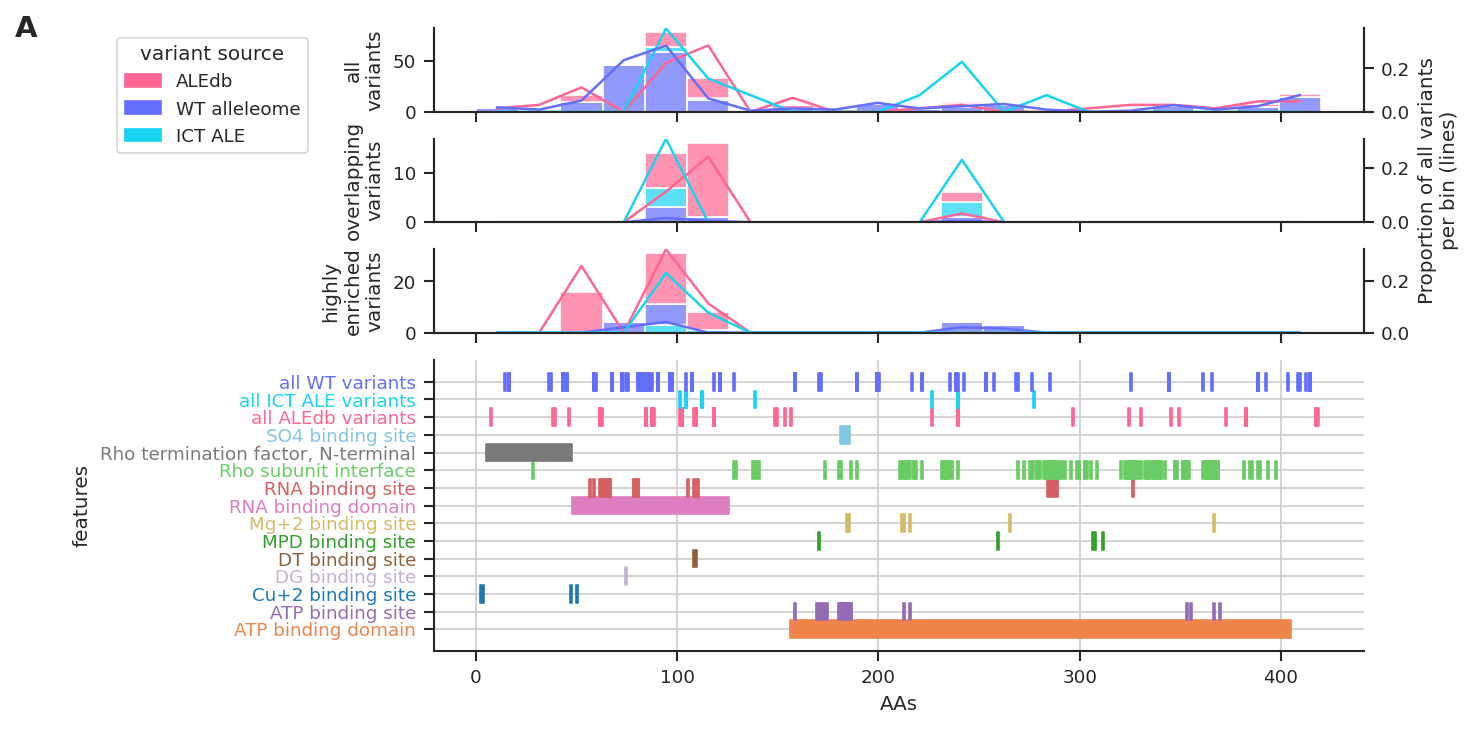

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
sns.set_palette("deep")
sns.set_context("paper")
sns.set_style("ticks")

# Set up the matplotlib figure with 2 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,5.5), gridspec_kw={'height_ratios': [2, 2, 2, 7]})


# Define the bin width and bins using global_min and global_max
bin_width = BIN_SIZE
bin_start = (all_var_aa_df['AA position'].min() // bin_width) * bin_width  # Ensure bin_start is a multiple of bin_width
bins = np.arange(bin_start, all_var_aa_df['AA position'].max() + bin_width, bin_width)


# full_data used to calculate the percentage of data points in each bin relative to full data each time
def plot_stacked_histogram(ax, curr_data, full_data, bins, cnt_y_axis_lbl, prop_y_axis_lbl):
    """
    Function to plot a stacked histogram with correctly aligned overlayed percentage lines using seaborn's lineplot on the provided Axes object.
    :param ax: Axes object to plot on.
    :param data: DataFrame containing the data to plot.
    :param bins: The bins to be used for histogram and lineplot.
    """
    # Calculate the mid-point of each bin after defining the histogram bins
    bin_mids = (bins[:-1] + bins[1:]) / 2
    
    # Create stacked histogram using seaborn's histplot with specified bins and color mapping
    sns.histplot(
        data=curr_data,
        x='AA position',
        hue='variant source', stat='count', multiple='stack',
        palette=const.VAR_SRC_COLOR_D, ax=ax, bins=bins,
        legend=False,
        alpha=0.7
        )
    ax.set_ylabel(cnt_y_axis_lbl)
    
    # Create a twin Axes sharing the xaxis
    ax_twin = ax.twinx()
    
    # Get the unique categories in "variant source" column
    variant_sources = curr_data['variant source'].unique()
    
    max_proportion = 0  # Initialize max_percentage to find the maximum percentage value across all lines
    
    # Iterate over each unique category in "variant source" column and plot the line using sns.lineplot with consistent color mapping
    for variant_source in variant_sources:
        # Filter the data for the specific variant source
        curr_filtered_data = curr_data[curr_data['variant source'] == variant_source]['AA position']
        curr_full_data = full_data[full_data['variant source'] == variant_source]['AA position']
        
        # Calculate the percentage of data points in each bin for the filtered data
        counts, _ = np.histogram(curr_filtered_data, bins=bins)
        proportions = (counts / len(curr_full_data))  # Convert counts to proportions
        max_proportion = max(max_proportion, proportions.max())  # Update max_proportions
        
        # Prepare a DataFrame for sns.lineplot
        line_data = pd.DataFrame({
            'Bin Mid': bin_mids,
            'Proportions': proportions
        })
        
        # Overlay the line plot describing the percentage of data points within each bin for the specific variant source using sns.lineplot with consistent color
        sns.lineplot(
            x='Bin Mid', y='Proportions',
            data=line_data,
            ax=ax_twin, color=const.VAR_SRC_COLOR_D[variant_source],
            legend=False)
    
    # Move the label and ticks of the percentage y-axis to the right side
    ax_twin.yaxis.set_label_position('right')
    ax_twin.yaxis.tick_right()
    ax_twin.set_ylabel(prop_y_axis_lbl)
    
    # Adjust the ylim of the twin axis to align the 0 position with the histogram's y-axis
    ax_twin.set_ylim(ax.get_ylim()[0] * (max_proportion / ax.get_ylim()[1]), max_proportion)

    ax.spines['top'].set_visible(False)
    ax_twin.spines['top'].set_visible(False)


plot_stacked_histogram(axes[0], all_var_aa_df, all_var_aa_df, bins, 'all\nvariants', '')
plot_stacked_histogram(axes[1], src_overlap_aa_df, all_var_aa_df, bins, 'overlapping\nvariants', 'Proportion of all variants\nper bin (lines)')
plot_stacked_histogram(axes[2], hi_enrch_aa_var_w_sv_df, all_var_aa_df, bins, 'highly\nenriched\nvariants', '')


feat_color_d = dict()
for _, r in feats_df.iterrows():
    feat_color_d[r["feature"]] = r["color"]

for _, r in combo_feats_df.iterrows():
    y_rng = (int(r.name)-0.5, 1)
    axes[3].broken_barh(r["range"], y_rng, color=feat_color_d[r['feature']])
axes[3].set_yticks(list(combo_feats_df.index))
axes[3].set_yticklabels(combo_feats_df["feature"])
axes[3].set_xlabel("AAs")
axes[3].set_ylabel("features")
axes[3].grid(True)
yticks = axes[3].get_yticklabels()
for i, label in enumerate(yticks):
    label.set_color(feat_color_d[combo_feats_df["feature"].iloc[i]])
sns.despine(ax=axes[3], top=True, left=False, right=True, bottom=False)

import matplotlib.patches as mpatches

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in const.VAR_SRC_COLOR_D.items()]
axes[0].legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(-0.35, 1), title="variant source")

axes[0].text(-0.45, 0.9, 'A', transform=axes[0].transAxes, weight='bold', fontsize=14)

plt.savefig("var_1d_dca.pdf", format="pdf", bbox_inches="tight")